In [ ]:
!pip install peft transformers accelerate bitsandbytes datasets trl
!pip install feedparser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
import torch
import feedparser
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, BitsAndBytesConfig
)

from peft import get_peft_model, LoraConfig, TaskType


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
rss_urls = {
    "BBC": "http://feeds.bbci.co.uk/news/rss.xml",
    "Reuters": "http://feeds.reuters.com/reuters/topNews",
    "NPR": "https://www.npr.org/rss/rss.php?id=1001"
}
real_news = []
for source, url in rss_urls.items():
    feed = feedparser.parse(url)
    for entry in feed.entries:
        real_news.append({"text": entry.title.strip(), "label": 1})
df_real_news = pd.DataFrame(real_news).drop_duplicates(subset="text")


df1 = pd.read_csv("/content/drive/MyDrive/misinfo_project/liar/liar_train.csv")
df2 = pd.read_csv("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_train.csv")
df_train = pd.concat([df1, df2, df_real_news], ignore_index=True)
df_train.dropna(subset=["text", "label"], inplace=True)
df_train["label"] = df_train["label"].astype(int)


df_real = df_train[df_train["label"] == 1]
df_train = pd.concat([df_train, df_real, df_real], ignore_index=True)


In [ ]:

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=df_train["label"]
)


class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)


Class weights: tensor([1.3526, 0.7932])


In [ ]:
model_name = "deepseek-ai/deepseek-llm-7b-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

In [ ]:
bnb_config = BitsAndBytesConfig(load_in_8bit=True)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto"
)

base_model.config.pad_token_id = tokenizer.pad_token_id

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()


config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/deepseek-llm-7b-base and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,940,352 || all params: 6,494,883,840 || trainable%: 0.0607


In [ ]:
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(tokenize, batched=True)
train_dataset = train_dataset.remove_columns(["text"])
train_dataset.set_format("torch")


Map:   0%|          | 0/18314 [00:00<?, ? examples/s]

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").to(torch.long)
        outputs = model(**inputs)
        logits = outputs.logits
        weight = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss_fn = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:


training_args = TrainingArguments(
    output_dir="./deepseek_output",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=5e-6,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    fp16=False,
    bf16=False,
    optim="adamw_torch_fused"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights
)
trainer.train()

<ipython-input-9-31041ea34719>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,0.862100
100,0.875200
150,0.848500
200,0.827100
250,0.807900
300,0.772200
350,0.772900
400,0.741600
450,0.720500
500,0.687300


Step,Training Loss
50,0.862100
100,0.875200
150,0.848500
200,0.827100
250,0.807900
300,0.772200
350,0.772900
400,0.741600
450,0.720500
500,0.687300


TrainOutput(global_step=6867, training_loss=0.6808891468595275, metrics={'train_runtime': 5294.2878, 'train_samples_per_second': 10.378, 'train_steps_per_second': 1.297, 'total_flos': 5.1254508247842816e+17, 'train_loss': 0.6808891468595275, 'epoch': 2.998908058528063})

In [ ]:
def load_test_data(path):
    df = pd.read_csv(path).dropna(subset=["text", "label"])
    df["label"] = df["label"].astype(int)
    dataset = Dataset.from_pandas(df).map(tokenize, batched=True)
    dataset = dataset.remove_columns(["text"])
    dataset.set_format("torch")
    return dataset

# Paths
test_paths = {
    "LIAR": "/content/drive/MyDrive/misinfo_project/liar/liar_test.csv",
    "FakeNewsNet": "/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv"
}

# Evaluate and log
results = {}
for name, path in test_paths.items():
    test_data = load_test_data(path)
    output = trainer.predict(test_data)
    preds = torch.argmax(torch.tensor(output.predictions), dim=1)
    labels = output.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    accuracy = accuracy_score(labels, preds)
    results[name] = {
        "accuracy": accuracy, "precision": precision,
        "recall": recall, "f1": f1
    }
    print(f"{name} results:", results[name])


Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

LIAR results: {'accuracy': 0.6045777426992897, 'precision': 0.45806451612903226, 'recall': 0.6325167037861915, 'f1': 0.5313376987839102}


Map:   0%|          | 0/85 [00:00<?, ? examples/s]

FakeNewsNet results: {'accuracy': 0.49411764705882355, 'precision': 0.4931506849315068, 'recall': 0.8571428571428571, 'f1': 0.6260869565217392}


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


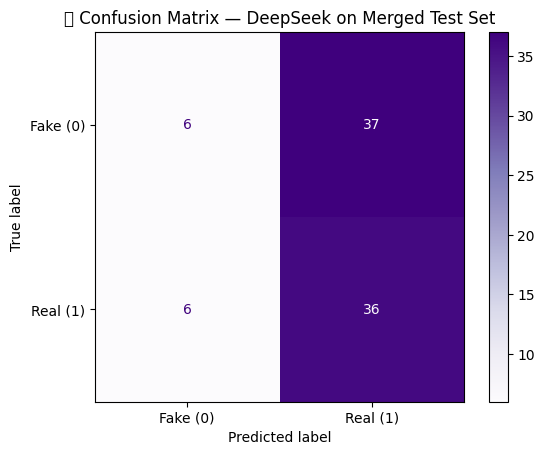

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake (0)", "Real (1)"])

# Plot
plt.figure(figsize=(6, 5))
disp.plot(cmap="Purples", values_format="d")
plt.title("🧠 Confusion Matrix — DeepSeek on Merged Test Set")
plt.grid(False)
plt.show()


In [ ]:
save_dir = "/content/drive/MyDrive/misinfo_project/models/deepseek_IT2"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)




('/content/drive/MyDrive/misinfo_project/models/deepseek_IT2/tokenizer_config.json',
 '/content/drive/MyDrive/misinfo_project/models/deepseek_IT2/special_tokens_map.json',
 '/content/drive/MyDrive/misinfo_project/models/deepseek_IT2/tokenizer.json')